In [1]:
#импортируем нужные нам библиотеки
import warnings                                 
warnings.filterwarnings('ignore')
#импортируем нужные нам библиотеки
import numpy as np                              
import pandas as pd                             
import matplotlib.pyplot as plt                  
import seaborn as sns                                         
import xgboost as xgb

from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

%matplotlib inline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

#загружаем данные
data = pd.read_excel('005_example.xlsx', axis=1)

In [2]:
#загружаем модель FbPropher
from fbprophet import Prophet

In [3]:
#данные
data

,date_id,good_id,ship_store_id,price,promo,sale,promo_price,holiday,owner_id
0,2018-09-16,149045,40,699,0,1,699,0,2
1,2018-03-17,149045,40,599,0,0,599,0,2
2,2018-03-23,149045,40,599,0,0,599,0,2
3,2017-07-25,149045,40,599,0,2,599,0,2
4,2018-10-04,173544,13,1399,0,0,1399,0,2
...,...,...,...,...,...,...,...,...,...
529572,2018-04-01,149079,77,399,0,6,0,0,9
529573,2018-03-29,149079,77,399,0,2,0,0,9
529574,2018-10-01,149079,77,499,0,0,0,0,9
529575,2019-05-27,149079,77,499,0,0,0,0,9


In [4]:
data['year'] = pd.DatetimeIndex(data['date_id']).year
data['month'] = pd.DatetimeIndex(data['date_id']).month
data['day'] = pd.DatetimeIndex(data['date_id']).day
data['WeekOfYear'] = pd.DatetimeIndex(data['date_id']).weekofyear

In [5]:
#группируем данные по неделям
table = data.groupby('date_id')['sale'].sum()
#сортируем данные от самых поздних дат до самых ранних
table = table.sort_index(ascending = False)
#создаем датафрейм
df = pd.DataFrame({'ds': table.index, 'y': table.values})
df

,ds,y
0,2019-12-01,906
1,2019-11-30,1292
2,2019-11-29,733
3,2019-11-28,469
4,2019-11-27,512
...,...,...
1029,2017-02-05,147
1030,2017-02-04,154
1031,2017-02-03,70
1032,2017-02-02,59


In [6]:
#импортируем модуль datetime
import datetime

In [7]:
#Приступаем к созданию тестовой и обучающей выборки. 
#В описании задания сказано, что модель должна рассчитывать прогноз на 45, 46, 47, 48 календарные недели
#разбиваем нашу выбору по нужному временному интервалу
split_date = datetime.datetime.strptime("2019-11-01", '%Y-%m-%d')

In [8]:
#Создаем тренировочную и тестовую выборку данных
d_train = df[df['ds'] < split_date]

d_test = df[df['ds'] >= split_date]

In [9]:
#У модели Facebook Prophet существует ряд гиперпараметров, 
#настройка оптимальных значений которых позволит увеличить эффективность прогнозирования
#однако при работе с моделью Prophet'а возникает две трудности


#Первая трудность заключается в том, что создание прогноза на уровне "номер магазина + номер товара" занимаем большое количество времени
#Если добавить к этому еще задачу, при которой модель также будет подбирать оптимальные гиперпараметры для каждого прогноза, 
#то время работы модели также увеличится в разы. К тому же мой компьютер довольно слабый для поставленных задача. 
#Поэтому было принято решение подобрать оптимальные на общих данных, агрегированных по неделям, и уже потом их использовать для каждой модели

#Вторая проблема заключается в том, что, к сожалению, модель FBProphet не поддерживает возможность использования GridSearchCV
#Поэтому подбор параметров будет происходить с помощью простой итерации
def checking_out_n(X, y):
    slov = {}
    number = []
    for i in range(30):
        number.append(i)
    for b in number:
        my_model = Prophet(interval_width = 0.95, yearly_seasonality=True, daily_seasonality=True, 
                   changepoint_prior_scale=6.5, n_changepoints = b)
        my_model.fit(X)
        forecast = my_model.predict(y)
        results = d_test.copy()
        results['fcst'] = forecast['yhat'].values
        results['MAPE'] = abs((results['y'] - results['fcst']) / results['y'] * 100)
        mape = results['MAPE'].sum()/31
        slov[b] = mape
    return pd.DataFrame(slov.values(), index=slov.keys(), columns = ['n_changepoints']) 

#Запускаем функцию и смотрим, какое значение гиперпараметра n_changepoints модели было бы для нас подходящим
checking_out_n(d_train, d_test).sort_values(by='n_changepoints')


In [10]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df['ds']
    df['dayofweek'] = df['ds'].dt.dayofweek
    df['quarter'] = df['ds'].dt.quarter
    df['month'] = df['ds'].dt.month
    df['year'] = df['ds'].dt.year
    df['dayofyear'] = df['ds'].dt.dayofyear
    df['dayofmonth'] = df['ds'].dt.day
    df['weekofyear'] = df['ds'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [11]:
X_train, y_train = create_features(d_train, label='y')

In [12]:
X_test, y_test = create_features(d_test, label='y')

In [13]:
#Загружаем нашу модель
my_model = xgb.XGBRegressor(n_estimators=1000)

In [14]:
#Фитим модель на данных
my_model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

[18:28:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [15]:
#Прогнозируем по тестовым данным
forecast = my_model.predict(X_test)

In [16]:
fc = X_test
fc['yhat'] = forecast
fc

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,yhat
0,6,4,12,2019,335,1,48,952.310486
1,5,4,11,2019,334,30,48,952.310486
2,4,4,11,2019,333,29,48,452.659363
3,3,4,11,2019,332,28,48,452.659363
4,2,4,11,2019,331,27,48,452.659363
5,1,4,11,2019,330,26,48,452.659363
6,0,4,11,2019,329,25,48,452.659363
7,6,4,11,2019,328,24,47,952.310486
8,5,4,11,2019,327,23,47,952.310486
9,4,4,11,2019,326,22,47,452.659363


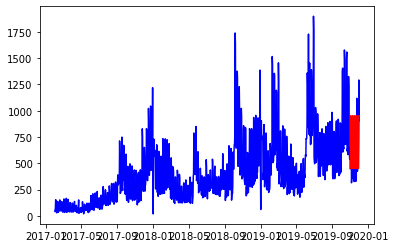

In [17]:
#Строим простой график факта к прогнозу
plt.plot(d_train['ds'], y_train,linestyle='-', color='b', label='train')
plt.plot(d_test['ds'], y_test,linestyle='-', color='b', label='train')
plt.plot(d_test['ds'], fc['yhat'], linestyle='-', color='r', label='forecast')

In [18]:
#Создаем датафрейм с сравнением данных по прогнозу и факту и высчитываем MAPE
results = d_test.copy()
results['forecast'] = fc['yhat'].values
results['MAPE'] = abs((results['y'] - results['forecast']) / results['y'] * 100)
results

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


,ds,y,date,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,forecast,MAPE
0,2019-12-01,906,2019-12-01,6,4,12,2019,335,1,48,952.310486,5.111533
1,2019-11-30,1292,2019-11-30,5,4,11,2019,334,30,48,952.310486,26.291758
2,2019-11-29,733,2019-11-29,4,4,11,2019,333,29,48,452.659363,38.245653
3,2019-11-28,469,2019-11-28,3,4,11,2019,332,28,48,452.659363,3.484144
4,2019-11-27,512,2019-11-27,2,4,11,2019,331,27,48,452.659363,11.589968
5,2019-11-26,469,2019-11-26,1,4,11,2019,330,26,48,452.659363,3.484144
6,2019-11-25,424,2019-11-25,0,4,11,2019,329,25,48,452.659363,6.759284
7,2019-11-24,1025,2019-11-24,6,4,11,2019,328,24,47,952.310486,7.091660
8,2019-11-23,1118,2019-11-23,5,4,11,2019,327,23,47,952.310486,14.820171
9,2019-11-22,567,2019-11-22,4,4,11,2019,326,22,47,452.659363,20.165897


In [19]:
results = d_test.copy()
results['forecast'] = fc['yhat'].values
results['MAPE'] = abs((results['y'] - results['forecast']) / results['y'] * 100)
results

,ds,y,date,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,forecast,MAPE
0,2019-12-01,906,2019-12-01,6,4,12,2019,335,1,48,952.310486,5.111533
1,2019-11-30,1292,2019-11-30,5,4,11,2019,334,30,48,952.310486,26.291758
2,2019-11-29,733,2019-11-29,4,4,11,2019,333,29,48,452.659363,38.245653
3,2019-11-28,469,2019-11-28,3,4,11,2019,332,28,48,452.659363,3.484144
4,2019-11-27,512,2019-11-27,2,4,11,2019,331,27,48,452.659363,11.589968
5,2019-11-26,469,2019-11-26,1,4,11,2019,330,26,48,452.659363,3.484144
6,2019-11-25,424,2019-11-25,0,4,11,2019,329,25,48,452.659363,6.759284
7,2019-11-24,1025,2019-11-24,6,4,11,2019,328,24,47,952.310486,7.091660
8,2019-11-23,1118,2019-11-23,5,4,11,2019,327,23,47,952.310486,14.820171
9,2019-11-22,567,2019-11-22,4,4,11,2019,326,22,47,452.659363,20.165897


In [20]:
#Показатель MAPE составил 33.73. Это лучший результат с установленным гиперпараметром
mape = results['MAPE'].sum()/31
mape

17.965145246424377

In [21]:
split_date = datetime.datetime.strptime("2019-11-01", '%Y-%m-%d')

In [22]:
data_test = data[data['date_id'] >= split_date]
data_test['store_and_id'] = data.apply(lambda x: f"{x['ship_store_id']} + {x['good_id']}", axis=1) 
                        

In [23]:
data_test

,date_id,good_id,ship_store_id,price,promo,sale,promo_price,holiday,owner_id,year,month,day,WeekOfYear,store_and_id
16,2019-11-09,173541,63,1299,0,0,1299,0,2,2019,11,9,45,63 + 173541
17,2019-11-15,173541,63,1299,0,0,1299,0,2,2019,11,15,46,63 + 173541
81,2019-11-11,162604,12,899,0,0,5299,0,2,2019,11,11,46,12 + 162604
82,2019-11-17,162604,12,899,0,0,4999,0,2,2019,11,17,46,12 + 162604
86,2019-11-14,162604,12,899,0,0,4999,0,2,2019,11,14,46,12 + 162604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529555,2019-11-06,96474,39,2599,0,0,0,0,2,2019,11,6,45,39 + 96474
529556,2019-11-12,96474,39,2599,0,0,0,0,2,2019,11,12,46,39 + 96474
529569,2019-11-26,149079,77,499,1,2,399,0,9,2019,11,26,48,77 + 149079
529570,2019-11-20,149079,77,499,0,0,0,0,9,2019,11,20,47,77 + 149079


In [24]:
#Однако при построении прогнозов для группы "номер магазина" + "номер товара" возникла проблема. 
#Оптимальные значения гиперпараметров (в нашем случае changepoint_prior_scale и n_changepoints), которые мы
#подобрали на агрегированных данных, показали плохой результат с дефолтными параметрами модели FB Prophet.
#В связи с тем, что это было бы весьма долго подбирать подходящие гиперпараметры для каждого прогноза, было решено запустить модель на дефолтных параметрах.

In [30]:
mape_slovar = {}
main_slovar_for_sale = {}
11 + 179697
data['store_and_id'] = data.apply(lambda x: f"{x['ship_store_id']} + {x['good_id']}", axis=1)
                                  

In [59]:
model = xgb.XGBRegressor(n_estimators=1000)

In [60]:
table = data[data['store_and_id'] == '11 + 179697']

In [61]:
table = table.groupby('date_id')['sale'].sum()

In [62]:
table = table.sort_index(ascending = False)

In [63]:
df = pd.DataFrame({'ds': table.index, 'y': table.values})

In [64]:
split_date = datetime.datetime.strptime("2019-11-01", '%Y-%m-%d')

In [65]:
d_train = df[df['ds'] < split_date]
d_test = df[df['ds'] >= split_date]

In [66]:
X_train, y_train = create_features(d_train, label='y')
X_test, y_test = create_features(d_test, label='y')

In [72]:
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50, verbose=False)

[19:14:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [74]:
forecast = model.predict(X_test)
forecast

array([0.17790726, 0.42830932, 0.20126101, 0.2703582 , 0.2703582 ,
       0.2528149 , 0.2528149 , 0.3413387 , 0.42830932, 0.22978055,
       0.22978055, 0.22978055, 0.21223724, 0.21223724, 0.40704554,
       0.42830932, 0.22978055, 0.22978055, 0.22978055, 0.21223724,
       0.17569843, 0.37571466, 0.5504269 , 0.19324175, 0.21301937,
       0.21301937, 0.19547608, 0.19547608, 0.17790726, 0.21374074,
       0.21301937], dtype=float32)

In [75]:
results = d_test.copy()

In [76]:
results['yhat'] = forecast

In [87]:
results['yhat'] = results['yhat'].round()

In [88]:
results['yhat'] = abs(results['yhat'])

In [90]:
results['MAPE'] = abs(results['y'] - results['yhat']) / (results[['y','yhat']].max(axis=1) + 0.01)

In [92]:
mape = results['MAPE'].sum()/len(results['MAPE'])

In [109]:
#Создание прогноза
#Теперь для создания прогноза по парам "магазин + товар" создадим спеицальную функцию.

mape_slovar = {}
main_slovar_for_sale = {}
#модель по магазинам
def funcck(data):
    #создаем новый столбец - результат конъюкции признаков "номер магазина" и "номер товара"
    data['store_and_id'] = data.apply(lambda x: f"{x['ship_store_id']} + {x['good_id']}", axis=1) 
    #запуск итерации по уникальным значениям столбца (коньюкция номера магазина и номера товара)
    for i in data['store_and_id'].unique():
        model = xgb.XGBRegressor(n_estimators=1000, booster = 'gbtree')
        #выбираем данные с указанным значением номера магазина и товара
        table = data[data['store_and_id'] == i]
        #группируем данные по продажам в неделю
        table = table.groupby('date_id')['sale'].sum()
        #устанавливаем значения индекса датафрейма нашими значениями datetime 
        table = table.sort_index(ascending = False)
        #создаем датафрейм для нашей модели со столбцами ds и y
        df = pd.DataFrame({'ds': table.index, 'y': table.values})
        #указываем промежуток для временного сплита
        split_date = datetime.datetime.strptime("2019-11-01", '%Y-%m-%d')
        #делим на тестовую и тренировочную выборку
        d_train = df[df['ds'] < split_date]
        d_test = df[df['ds'] >= split_date]
        #фитим модель
        X_train, y_train = create_features(d_train, label='y')
        X_test, y_test = create_features(d_test, label='y')                              
        model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50, verbose=False)
        #прогнозируем по новым данным
        forecast = model.predict(X_test)    
        results = d_test.copy()
        results['yhat'] = forecast
        #выделяем полученные спрогнозированные данные
        results['yhat'] = results['yhat'].round()    
        results['yhat'] = abs(results['yhat'])
        #находим значение MAPE на каждую неделю прогноза
        results['MAPE'] = abs(results['y'] - results['yhat']) / (results[['y','yhat']].max(axis=1) + 0.01)
        #находим среднее значение Mape по всему прогнозу магазина + товара
        mape = results['MAPE'].sum()/len(results['MAPE'])
        mape_slovar[i] = mape
        results['time+good+shop'] = results.apply(lambda x: f"{x['ds']} + {i}", axis=1)
        slovar_for_sales = results.groupby('time+good+shop')['y'].sum().to_dict()
        main_slovar_for_sale.update(slovar_for_sales)                                         
    data_test['MAPE'] = data_test['store_and_id'].replace(mape_slovar) 
    data_test['time+good+shop'] = data_test.apply(lambda x: f"{x['date_id']} + {x['store_and_id']}", axis=1)
    data_test['y'] = data_test['time+good+shop'].replace(main_slovar_for_sale) 
    return data_test

#Используем функцию прогноза на данных
end_table = funcck(data)

[21:14:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[21:14:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[21:14:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[21:14:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[21:14:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[21:14:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[21:15:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[21:15:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[21:15:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[21:15:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[21:15:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[21:15:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:16:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:16:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:16:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:16:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:16:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[21:16:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:16:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:16:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:16:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:16:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:16:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:16:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:16:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:16:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [110]:
#Создаем столбец со значением 1 - MAPE
end_table['1 - Mape'] = 1 - end_table['MAPE']
#Высчитываем среднее значение параметра 1 - MAPE
end_table['1 - Mape'].mean()

0.5949917756284812

In [ ]:
#Выделяем значения недели
end_table['WeekOfYear'] = pd.DatetimeIndex(end_table['date_id']).weekofyear

In [ ]:
#4 прогнозируемые недели
end_table['WeekOfYear'].unique()

In [104]:
#Выделяем нужные колонки
Final = end_table[['good_id','ship_store_id', 'date_id', 'promo', 'sale', 'y']]

In [105]:
Final.rename(columns={'y': 'sale_predict'}, inplace=True)

In [ ]:
Final

In [ ]:
dsfadsfadsf

In [ ]:
#Выгружаем в ексель
Final.to_excel("Hoff_excel.xlsx")

In [ ]:
#Значения 1 - Mape для 4 недель
for i in end_table['WeekOfYear'].unique():
    print('Номер недели', end_table[end_table['WeekOfYear'] == i]['1 - Mape'].mean())